In [66]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
df = pd.read_csv(('../data/feature_engineered.csv'))
df.set_index('Timestamp', inplace=True)

In [67]:
train_test_split = 0.2
train_size = int((1 - train_test_split) * len(df))
df_train = df.iloc[:train_size]
df_test  = df.iloc[train_size:]

In [68]:
#tune_split = int(0.8 * len(df_train))
#train_tune = df_train.iloc[:tune_split]
#val_tune   = df_train.iloc[tune_split:]

X_train_tune = df_train.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_train_tune = df_train['load_da']

#X_val_tune = df_test.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
#y_val_tune = df_test['load_da']

X_test_tune = df_test.drop(['Power Consumption (kW)', 'load_da', 'load_d2'], axis=1)
y_test_tune = df_test['load_da']

In [69]:
import mapie
print(mapie.__version__)


1.1.0


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import joblib
joblib.parallel_backend('threading')


quantiles = [0.1, 0.5, 0.9]
preds = {}


from skopt.space import Real, Integer

param_space = {
    'n_estimators': Integer(400, 800),
    'max_depth': Integer(2, 7),
    'learning_rate': Real(0.0001, 0.1, prior='log-uniform'),
    'min_samples_split': Integer(4, 12),
    'min_samples_leaf': Integer(4, 8),
    'subsample': Real(0.5, 1.0)
}

tscv = TimeSeriesSplit(n_splits=5)

gbr_base = GradientBoostingRegressor(loss="quantile", alpha=0.5, random_state=42)

gbr_opt = BayesSearchCV(
    estimator=gbr_base,
    search_spaces=param_space,
    n_iter=40,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    random_state=42,
    verbose=2
)

gbr_opt.fit(X_train_tune, y_train_tune)

print("Best Median Model Parameters:", gbr_opt.best_params_)
print("Best Median CV RMSE:", -gbr_opt.best_score_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.0016994636371262762, max_depth=6, min_samples_leaf=8, min_samples_split=7, n_estimators=668, subsample=0.7070593162427692; total time=   0.3s
[CV] END learning_rate=0.0016994636371262762, max_depth=6, min_samples_leaf=8, min_samples_split=7, n_estimators=668, subsample=0.7070593162427692; total time=   0.6s
[CV] END learning_rate=0.0016994636371262762, max_depth=6, min_samples_leaf=8, min_samples_split=7, n_estimators=668, subsample=0.7070593162427692; total time=   0.9s
[CV] END learning_rate=0.0016994636371262762, max_depth=6, min_samples_leaf=8, min_samples_split=7, n_estimators=668, subsample=0.7070593162427692; total time=   1.1s
[CV] END learning_rate=0.0016994636371262762, max_depth=6, min_samples_leaf=8, min_samples_split=7, n_estimators=668, subsample=0.7070593162427692; total time=   1.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.03252108800594495, max

In [71]:
best_params = gbr_opt.best_params_
quantiles = [0.1, 0.5, 0.9]
models = {}
preds = {}

for q in quantiles:
    gbr = GradientBoostingRegressor(
        loss="quantile",
        alpha=q,
        random_state=42,
        **best_params
    )
    gbr.fit(X_train_tune, y_train_tune)
    models[q] = gbr
    preds[q] = gbr.predict(X_test_tune)


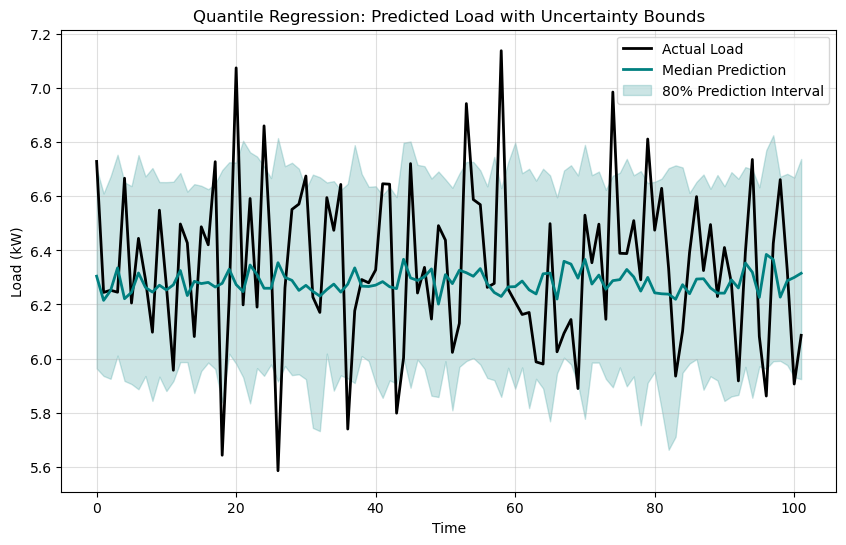

In [72]:
plt.figure(figsize=(10,6))
plt.plot(y_test_tune.values, label="Actual Load", color="black", linewidth=2)
plt.plot(preds[0.5], label="Median Prediction", color="teal", linewidth=2)
plt.fill_between(
    np.arange(len(y_test_tune)),
    preds[0.1],
    preds[0.9],
    color="teal", alpha=0.2, label="80% Prediction Interval"
)
plt.title("Quantile Regression: Predicted Load with Uncertainty Bounds")
plt.xlabel("Time")
plt.ylabel("Load (kW)")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [73]:
from sklearn.metrics import mean_pinball_loss

for q in quantiles:
    y_pred = preds[q]
    pinball = mean_pinball_loss(y_test_tune, y_pred, alpha=q)
    print(f"Quantile {q}: Pinball Loss = {pinball:.5f}")


Quantile 0.1: Pinball Loss = 0.05153
Quantile 0.5: Pinball Loss = 0.11677
Quantile 0.9: Pinball Loss = 0.05411


In [74]:
for q in quantiles:
    y_train_pred = models[q].predict(X_train_tune)
    pinball = mean_pinball_loss(y_train_tune, y_train_pred, alpha=q)
    print(f"Quantile {q}: Pinball Loss = {pinball:.5f}")
    



Quantile 0.1: Pinball Loss = 0.04585
Quantile 0.5: Pinball Loss = 0.11026
Quantile 0.9: Pinball Loss = 0.04900


In [75]:
q

0.9